In [1]:
import json
import random
import glob
import os
import shutil

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# 전역변수 설정
# 색상(list) (총 24개)
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255),
          (0, 255, 255), (255, 128, 0), (128, 0, 255), (0, 255, 128), (255, 128, 128),
          (128, 255, 128), (128, 128, 255), (128, 128, 0), (128, 0, 128), (0, 128, 128),
          (192, 64, 0), (192, 192, 64), (64, 192, 192), (64, 64, 192), (192, 64, 192),
          (64, 192, 64), (255, 192, 128), (128, 255, 192), (128, 192, 255)]

# 라벨이름(dict) : area_code 및 PM_code (총 35개)
# 주의 : 원본데이터에서 라벨 34는 제외되어있음. 즉 1부터36까지 34제외하고 35개
LABEL_NAMES = ['인도', '횡단보도', '자전거 도로', '교차로', '중앙 차선', '안전지대',
              '정지선', '정지선 위반 판별구역', '보행자 신호등 녹색', '보행자 신호등 적색',
              '차량 신호등 녹색', '차량 신호등 적색', '오토바이', '오토바이_보행자도로 통행위반',
              '오토바이_안전모 미착용', '오토바이_무단횡단', '오토바이_신호위반', '오토바이_정지선위반',
              '오토바이_횡단보도 주행위반', '자전거', '자전거 캐리어', '자전거_보행자도로 통행위반',
              '자전거_안전모 미착용', '자전거_무단횡단', '자전거_신호위반', '자전거_정지선위반',
              '자전거_횡단보도 주행위반', '킥보드', '킥보드 캐리어', '킥보드_보행자도로 통행위반',
              '킥보드_안전모 미착용', '킥보드_무단횡단', '킥보드_신호위반', '킥보드_횡단보도 주행위반',
              '킥보드_동승자 탑승위반']
LABEL_NAME = {str(k):v for k, v in zip(list(range(1,34)) + [35, 36], LABEL_NAMES)}

# 블랙박스에서 위반사항만 검출하기위한 라벨
LABEL_NAMES2 = ['오토바이_보행자도로 통행위반', '오토바이_안전모 미착용', '오토바이_무단횡단',
                '오토바이_신호위반', '오토바이_정지선위반', '오토바이_횡단보도 주행위반',
                '자전거 캐리어', '자전거_보행자도로 통행위반', '자전거_안전모 미착용',
                '자전거_무단횡단', '자전거_신호위반', '자전거_정지선위반', '자전거_횡단보도 주행위반',
                '킥보드 캐리어', '킥보드_보행자도로 통행위반', '킥보드_안전모 미착용', '킥보드_무단횡단',
                '킥보드_신호위반', '킥보드_횡단보도 주행위반', '킥보드_동승자 탑승위반']


# data폴더 상대경로
FILE_PATH = 'data'

# 샘플 annot과 img확인 (파일없으면 랜덤으로)
def random_sample(file=None):
    """
    랜덤 이미지와 그에 맞는 라벨을 뽑아주는 함수
    """
    if file:
        choice = glob.glob(FILE_PATH + f'/라벨링데이터/**/{file}', recursive=True)
        choice = choice[0]
    else:
        # file이 입력이 없으면 data폴더안에 아무 json 선택
        choice = random.choice(
            glob.glob(FILE_PATH + '/**/*.json', recursive=True)
        )
    # json과 그에 맞는 jpg 불러오기
    with open(choice, 'r') as f:
        annot = json.load(f)

    choice = choice.replace('라벨링데이터', '원천데이터').replace('.json', '.jpg')
    img = Image.open(choice)

    return annot, img


# annotation 포함된 이미지 확인
def pic_with_annotation(annot, img):
    """
    라벨(Seg, bbox)을 이미지에 올려주는 함수
    """
    draw = ImageDraw.Draw(img, 'RGBA')
    font = ImageFont.truetype("./batang.ttc", 30)

    # polygon은 1부터 12까지 12종류의 고유한 area_code를 가진다.
    # 그에 맞는 고유 색상 매핑
    poly_color = {str(k):(r, g, b, 70) for k, (r, g, b) in \
                  zip(range(1,13), COLORS)}
    # 위반코드는 13부터 36까지 (34제외하고) 23종류의 고유한 PM_code를 가진다.
    # 그에 맞는 색상 매핑
    box_color = {str(k):(r, g, b, 255) for k, (r, g, b) in \
                  zip(range(13, 37), COLORS)}

    # polygon 그리기
    for seg in annot['annotations']['environment']:
        area_code = seg['area_code']
        # 원본 좌표가 y,x 로 되어있으므로 뒤집기
        points = [(x,y) for [y, x] in seg['points']]

        draw.polygon(points, fill=poly_color[area_code])
    
    # bbox 그리기
    for box in annot['annotations']['PM']:
        PM_code = box['PM_code']
        # points 양식은 [left, top, width, height] 이다.
        # PIL 양식은 [x0, y0, x1, y1] 이므로 이에 맞게 변환
        # 이때 x0, y0 : 왼쪽상단, x1, y1 : 오른쪽하단
        left, top, width, height = box['points']
        points = [left, top, left+width, top+height]

        draw.rectangle(points, outline=box_color[PM_code], width=3)

        text = LABEL_NAME[PM_code]
        tbbox = draw.textbbox([points[0], points[1]-31], text, font=font)
        draw.rectangle(tbbox, fill=box_color[PM_code])
        draw.text([points[0], points[1]-31], text, font=font, fill='black')


# yolo format의 Groud Truth 확인
def yolo_gt(file=None):
    if not file:
        file = random.choice(glob.glob('data/coco/test/*.txt'))

    with open(file, 'r') as f:
        annot = f.read()

    img = Image.open(file.replace('.txt', '.jpg'))
    draw = ImageDraw.Draw(img, 'RGB')

    for line in annot.split('\n'):
        width = img.size[0]
        height = img.size[1]
        bbox = list(map(float, line.split(' ')))[1:]
        x0 = (bbox[0] - bbox[2]/2) * width
        y0 = (bbox[1] - bbox[3]/2) * height
        x1 = (bbox[0] + bbox[2]/2) * width
        y1 = (bbox[1] + bbox[3]/2) * height
        draw.rectangle([x0,y0,x1,y1], outline='red', width=3)
    return img


In [33]:
# COCO 형식에서 YOLO에 맞는 형태로 변환
# YOLOv5 라벨형식 : class_label, x_mid(0~1), y_mid(0~1), width(0~1), height(0~1) (txt파일)
# 그림 사이즈는 (1920*1080), (3072*1728) 로 두개이다.
def coco_to_yolo(file, mode='train'):
    """
    coco annotation을 YOLOv5 format으로 변경해누즌 함수
    Bounding Box와 라벨만 변환
    """
    # json dict가 아니라 경로로 되있으면 dict로 변환
    if isinstance(file, str):
        with open(file, 'r') as f:
            file = json.load(f)


    print(f'{mode} annotation 변환')
    # image_id 별로 annotation추가 (string형식)
    yolo_annots = {}
    for annot in tqdm.tqdm(file['annotations'], desc='annot처리중'):
        img_id = annot['image_id']
        # YOLO의 라벨은 0부터 시작한다! COCO는 1부터 시작하므로 1빼기
        label = annot['category_id'] - 1  
        left = annot['bbox'][0]
        top = annot['bbox'][1]
        width = annot['bbox'][2]
        height = annot['bbox'][3]

        x = (left + width/2)
        y = (top + height/2)

        width = width
        height = height

        yolo_annots.setdefault(img_id, '')
        yolo_annots[img_id] += f'{label} {x:.5f} {y:.5f} {width:.5f} {height:.5f}\n'

    # image 별로 annotation을 txt파일로 저장
    for image in tqdm.tqdm(file['images'], desc='.txt로 저장중'):
        file_name = image['file_name'].replace('.jpg', '.txt')
        img_width = image['width']
        img_height = image['height']
        img_id = image['id']

        # 이미지 크기로 bbox정규화
        reg_annots = ''
        for line in yolo_annots[img_id][:-1].split('\n'):
            ls = line.split(' ')
            ls[1] = float(ls[1]) / img_width
            ls[2] = float(ls[2]) / img_height
            ls[3] = float(ls[3]) / img_width
            ls[4] = float(ls[4]) / img_height

            # 이상하면 그림 불러와서 사이즈 재확인
            if ls[1] > 1 or ls[2] > 1 or ls[3] > 1 or ls[4] > 1:
                with Image.open(os.path.join('data/coco/', mode, file_name.replace('.txt', '.jpg'))) as img:
                    real_width, real_height = img.size

                ls[1] = ls[1] * img_width / real_width
                ls[2] = ls[2] * img_height / real_height
                ls[3] = ls[3] * img_width / real_width
                ls[4] = ls[4] * img_height / real_height
                print(f'파일 {file_name} 표시 {img_width}*{img_height}\t실제 {real_width}*{real_height}로 정규화됨')
            # nan있으면 넘어가기
            if any(np.isnan(i) for i in ls[1:]):
                print(f'파일 {file_name} nan발생 {ls[1]}, {ls[2]}, {ls[3]}, {ls[4]}')
                continue
                
            assert ls[1] <= 1, f'x이상 {ls[1]}, width {img_width} img_id {img_id} file name {file_name}'
            assert ls[2] <= 1, f'y이상 {ls[2]}, height {img_height} img_id {img_id} file name {file_name}'
            assert ls[3] <= 1, f'w이상 {ls[3]}, width {img_width} img_id {img_id} file name {file_name}'
            assert ls[4] <= 1, f'h이상 {ls[4]}, height {img_height} img_id {img_id} file name {file_name}'
            reg_annots += f'{ls[0]} {ls[1]:.5f} {ls[2]:.5f} {ls[3]:.5f} {ls[4]:.5f}\n'
        reg_annots = reg_annots[:-1]

        # 이미지와 같은 디렉토리에 txt저장
        with open(os.path.join(FILE_PATH, 'coco', mode, file_name), 'w') as f:
            f.write(reg_annots)
        
    return 

# 특정경로의 txt 모두 제거
def txt_remove(path): 
    for file in glob.glob(os.path.join(path, '*.txt')):
        os.remove(file)

# coco_to_yolo('data/coco/coco_annotations/test_annotations.json', mode='test')
# coco_to_yolo('data/coco/coco_annotations/valid_annotations.json', mode='val')
# coco_to_yolo('data/coco/coco_annotations/train_annotations.json', mode='train')

In [37]:
# 블랙박스용으로, 훈련용 블랙박스데이터 11.5GB, 검증용 1.3GB 변환

def to_YOLO_blackbox(mode='train'):
    # 블랙박스 데이터 폴더 생성
    os.makedirs(FILE_PATH + '/blackbox_yolo', exist_ok=True)
    os.makedirs(FILE_PATH + '/blackbox_yolo/val', exist_ok=True)
    os.makedirs(FILE_PATH + '/blackbox_yolo/train', exist_ok=True)

    # x-labeller포맷변환
    path = '/블랙박스/라벨링데이터/**/*.json' if mode=='train' else '/라벨링데이터/**/*_B_*.json'
    jsons = glob.glob(FILE_PATH + path, recursive=True)
    yolo_label_dict = dict(zip([i for i in range(13, 37) if i not in [13, 20, 28, 34]], range(len(LABEL_NAMES2))))

    for file in tqdm.tqdm(jsons, desc=f'블랙박스 {mode} 변환중'):
        with open(file, 'r') as f:
            annot = json.load(f)

        jpg_file = file.replace('라벨링데이터', '원천데이터').replace('.json', '.jpg')
        jpg = Image.open(jpg_file)
        img_width, img_height = jpg.size

        # bbox와 카테고리 변환
        string = ''
        
        for seg in annot['annotations']['PM']:
            # 오토바이(13), 자전거(20), 킥보드(28)는 위반사항이 아니므로 넘어가기
            # 이후 14~36까지 되있는 라벨을 0~19까지로 변환
            if (label:=int(seg['PM_code'])) in [13, 20, 28]:
                continue
            else:
                label = yolo_label_dict[label]

            left, top, width, height = seg['points']
            # 0~1 사이로 정규화
            x = (left + width/2) / img_width
            y = (top + height/2) / img_height
            width = width / img_width
            height = height / img_height

            string += f'{label} {x:.5f} {y:.5f} {width:.5f} {height:.5f}\n'
        string = string[:-1]

        # blackbox_yolo/train에 img옮기고 txt추가
        shutil.copy(jpg_file, FILE_PATH + f'/blackbox_yolo/{mode}/{os.path.basename(jpg_file)}')
        # 있는라벨들을 제거했기때문에, bbox가 없는 이미지들이 있다.
        # 해당이미지들은 배경이미지로 학습되도록 annotation파일 만들지 않기
        if bool(string) is True:
            with open(FILE_PATH + f'/blackbox_yolo/{mode}/' + os.path.basename(file).replace('.json', '.txt'), 'w') as f:
                f.write(string)
    

to_YOLO_blackbox(mode='val')
to_YOLO_blackbox(mode='train')
# train 23187개
# val 2732개
# 이중에 txt로 annotation이 있는게 절반정도.. 나머진 위반사항 없이 자전거, 오토바이, 킥보드만 있다.

블랙박스 train 변환중: 100%|██████████| 23187/23187 [05:08<00:00, 75.25it/s] 


## YOLOv8 훈련 및 평가

In [2]:
# YAML파일 작성

yaml = f"""# YOLOv8 설정파일
# 경로설정
path: ../{FILE_PATH}/coco/ # root (루트이전에 기본 datasets폴더를 가정하므로 ..로 한번 나가기)
train: train
val: val
test: test

# 클래스 설정
nc: 23
names: {LABEL_NAMES[12:]}
"""

with open('yolo_train.yaml', 'w') as f:
    f.write(yaml)

In [2]:
# nano모델 훈련
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # kernel crash 방지
# 디버깅 옵션
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 학습 (파라미터 3M)
# results = model.train(data='yolo_train.yaml',
#                       epochs=50,
#                       batch=32,
#                       imgsz=640,
#                       close_mosaic=0,
#                       workers=4,
#                       save_period=5)

# 사이트 패키지 설치장소 Lib\site-packages\ultralytics\utils\plotting.py
# 에 plt.rcParams['font.family'] = 'Gulim' 적용해야 한글라벨 정상출력
# close_mosaic=0 으로 설정해서 mosaic augumentation 적용해제 가능

In [3]:
# 훈련된 모델 불러와서 검증
model = YOLO('runs/detect/train/weights/best.pt')

# metrics = model.val()

mAP@50-95   : 0.551
mAP@50      : 0.723
mAP@75      : 0.664
inferece speed : 14.592ms


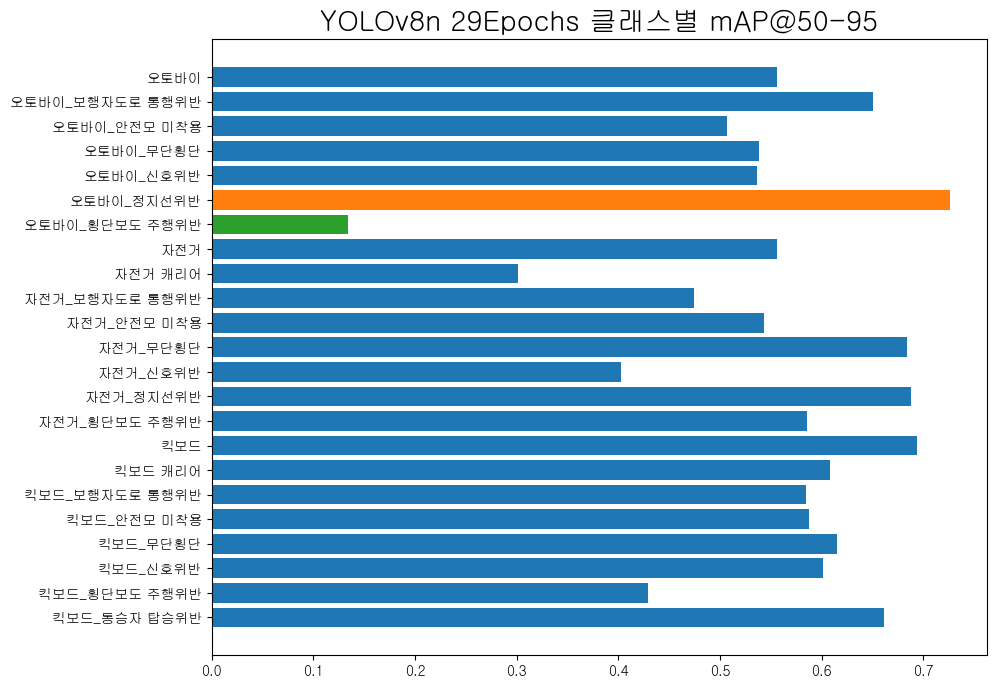

In [135]:
print(f'mAP@50-95   : {metrics.box.map:.3f}')
print(f'mAP@50      : {metrics.box.map50:.3f}')
print(f'mAP@75      : {metrics.box.map75:.3f}')
print(f'inferece speed : {metrics.speed["inference"]:.3f}ms')

cls_maps = [metrics.maps[i] for i in range(23)][::-1]
cls_names = [metrics.names[i] for i in range(23)][::-1]
c = ['C1' if i==max(cls_maps) else 'C2' if i==min(cls_maps) else 'C0' for i in cls_maps]
plt.figure(figsize=(10,8))
plt.barh(cls_names, cls_maps, color=c)
plt.title('YOLOv8n 29Epochs 클래스별 mAP@50-95', fontsize=20)
plt.show()

# 오토바이_정지선위반이 가장 정확도가 낮다. (~0.72)
# 오토바이_횡단보도 주행위반이 가장 정확도가 낮다. (~0.14)

## RT-DETR 훈련 및 평가

In [138]:
# YAML파일 작성

yaml = f"""# RT-DETR-l 설정파일
# 경로설정
path: ../{FILE_PATH}/coco/ # root (루트이전에 기본 datasets폴더를 가정하므로 ..로 한번 나가기)
train: train
val: val
test: test

# 클래스 설정
nc: 23
names: {LABEL_NAMES[12:]}
"""

with open('rtdetr_train.yaml', 'w') as f:
    f.write(yaml)

In [12]:
from ultralytics import RTDETR
# 훈련시간이 길것으로 예상..

model2 = RTDETR('rtdetr-l.pt')

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # kernel crash 방지
# 디버깅 옵션
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 모델 학습 (파라미터 32M)
results = model2.train(data='rtdetr_train.yaml',
                       epochs=5,
                       batch=4,
                       imgsz=640,
                       close_mosaic=2,
                       workers=4,
                       project='RTDETR',
                       name='detect',
                       freeze=1)

In [36]:
model2.model

DetectionModel(
  (model): Sequential(
    (0): HGStem(
      (stem1): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem2a): Conv(
        (conv): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem2b): Conv(
        (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem3): Conv(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (